## Overview

This Python script is designed to process ".avi" video files captured from the screen of the computer using the LP50 Dropwatching Visualization Software. The script performs several operations on the video frames to analyze the total gray values and visualize them over time.
***
## What the script does:

* [1. Initial processing:](#Initial_processing)
    * Converts each frame of the video to grayscale.
    * Calculates the total gray value for each frame by summing the gray values of all pixels.
    * Generates two plots:
      * Total gray value vs frame index.
      * Total gray value vs elapsed time by automatically extracting the frame rate of the video.
    * Allows the user to select a time interval for data processing. format: start,finish e.g 30,80 selects the interval from 30s to 80s.
    * Normalizes, inverts, and vertically shifts the processed data (The Lowest total gray values are now the peaks in the graph) .
* [2. Filter values:](#filter_values)
    * Removes all the points that are bellow a certain threshold given by the user.
    * This step helps removing outliers for the moving average
    * ```threshold``` : threshold value from 0 to 1
* [3. Peak selection:](#peak_selection)
    * Moving average for the filtered window and peak selection at a threshold above the moving average
    * ```mv_average_window``` : sets the number of points for the moving average window. Note: higher values smooth out the average.
    * ```offset_moving_average``` : Sets the offset above the moving average where peaks will be considered.
    * The selected peaks are represented in the plot along with there frame index.
* [4. Selected ROI:](#ROI)
    * Displays the selected ROI in one of the peak frames
* [5. Peak frames:](#peak_frames)
    * Displays all of the frames of the selected peaks
* [6. Statistics:](#statistics)
    * Finds the timing difference between consecutive peaks
    * Gets the mean time diference between peaks, the standard deviation and the mean ejection frequency.
    * Plots an histogram of the time diferences between peaks
* [Tests:](#tests)
    * Random tests on the aquired results

***
## Useful functions:

* [Crop video to size](#croping_function)
* [Show specific frame by index](#Show_frame_function)

***
## Usage

* Ensure you have Python installed on your system along with the necessary libraries: cv2, numpy, and matplotlib.
* Run the script providing the path to the input ".avi" video file as the video_path variable. The video file must be in the same directory as this script.
* Follow the prompts to select a time interval for data processing. You can enter the start and end times in seconds to define the interval.
* The script will generate plots showing the processed gray values for the chosen interval.
***
## Notes

* Converting frames to grayscale helps simplify the analysis by focusing on the intensity of the image rather than its color.
* Total gray values provide a quantitative measure of the overall brightness of each frame.
* The moving average was used since the background of the video is not constant over time, some shading diferences seem to be noticeable in the frames

    


In [59]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from scipy.fft import fft
from scipy.signal import find_peaks
from scipy.stats import norm
from IPython.display import display, Markdown, Latex
import tkinter as tk
from tkinter import simpledialog


import tkinter as tk
from tkinter import filedialog
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.patches import Rectangle
from matplotlib.figure import Figure
from tkinter import filedialog, Entry

from sklearn.linear_model import LinearRegression
import os
import re
import csv


<h1><a id='Show_frame_function'>
Show frame with a given index
</a>
</h1>

In [60]:
def show_frame_idx(cap,frame_index):
    # Set the frame position to the specified index
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # Read the frame
    ret, frame = cap.read()
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate the total gray value of the frame
    total_gray_value = gray_frame.sum()
    print("Frame: ",frame_index," Total gray value: ",total_gray_value)

    # Check if the frame is read correctly
    if not ret:
        print("Error: Unable to read frame.")
        exit()

    plt.figure()
    plt.imshow(frame)
    plt.show()

<h1><a id='Initial_processing'>
1.Initial processing
</a>
</h1>

Directories in C:\Users\peter\INL\EHD Printing - General\Development\Scripts
1. 2024-02-15
2. 2024-02-22
3. 2024-02-26
4. 2024-03-04
Choose a directory (1 - 4): 3
Directories in C:\Users\peter\INL\EHD Printing - General\Development\Scripts\2024-02-26
1. 50Hz_+_16.6mm_DC_1.49kV_1.0mm
2. 50Hz_+_16.6mm_DC_1.49kV_1.1mm
3. 50Hz_+_16.6mm_DC_1.49kV_1.2mm
4. 50Hz_+_16.6mm_DC_1.49kV_1.3mm
5. 50Hz_+_21.6mm_DC_1.49kV_1.0mm
6. 50Hz_+_21.6mm_DC_1.49kV_1.1mm
7. 50Hz_+_21.6mm_DC_1.49kV_1.2mm
8. 50Hz_+_21.6mm_DC_1.49kV_1.3mm
9. 50Hz_+_25.0mm_DC_1.49kV_1.3mm
10. 50Hz_+_28.6mm_DC_1.49kV_1.3mm
11. 50Hz_+_33.6mm_DC_1.49kV_1.3mm
12. 50Hz_+_39.2mm_DC_1.49kV_1.3mm
Choose a directory (1 - 12): 9
Video path: C:\Users\peter\INL\EHD Printing - General\Development\Scripts\2024-02-26\50Hz_+_25.0mm_DC_1.49kV_1.3mm\50Hz_+_25.0mm_DC_1.49kV_1.3mm.avi
Frame rate: 10.0  fps


## Total gray values for each frame

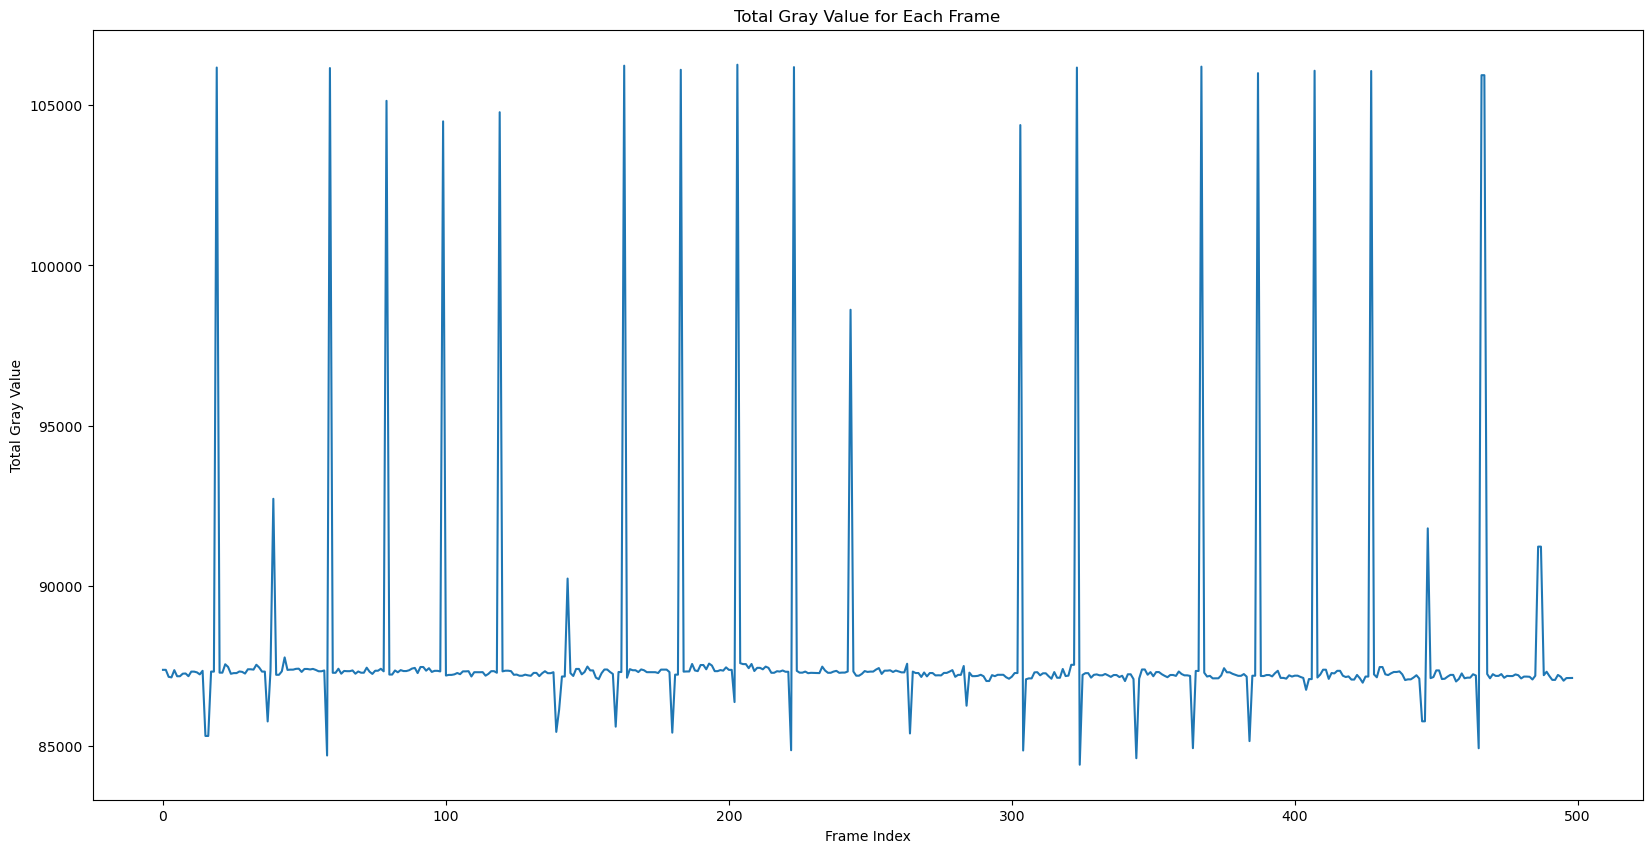

# Converting frame index to time using the frame rate

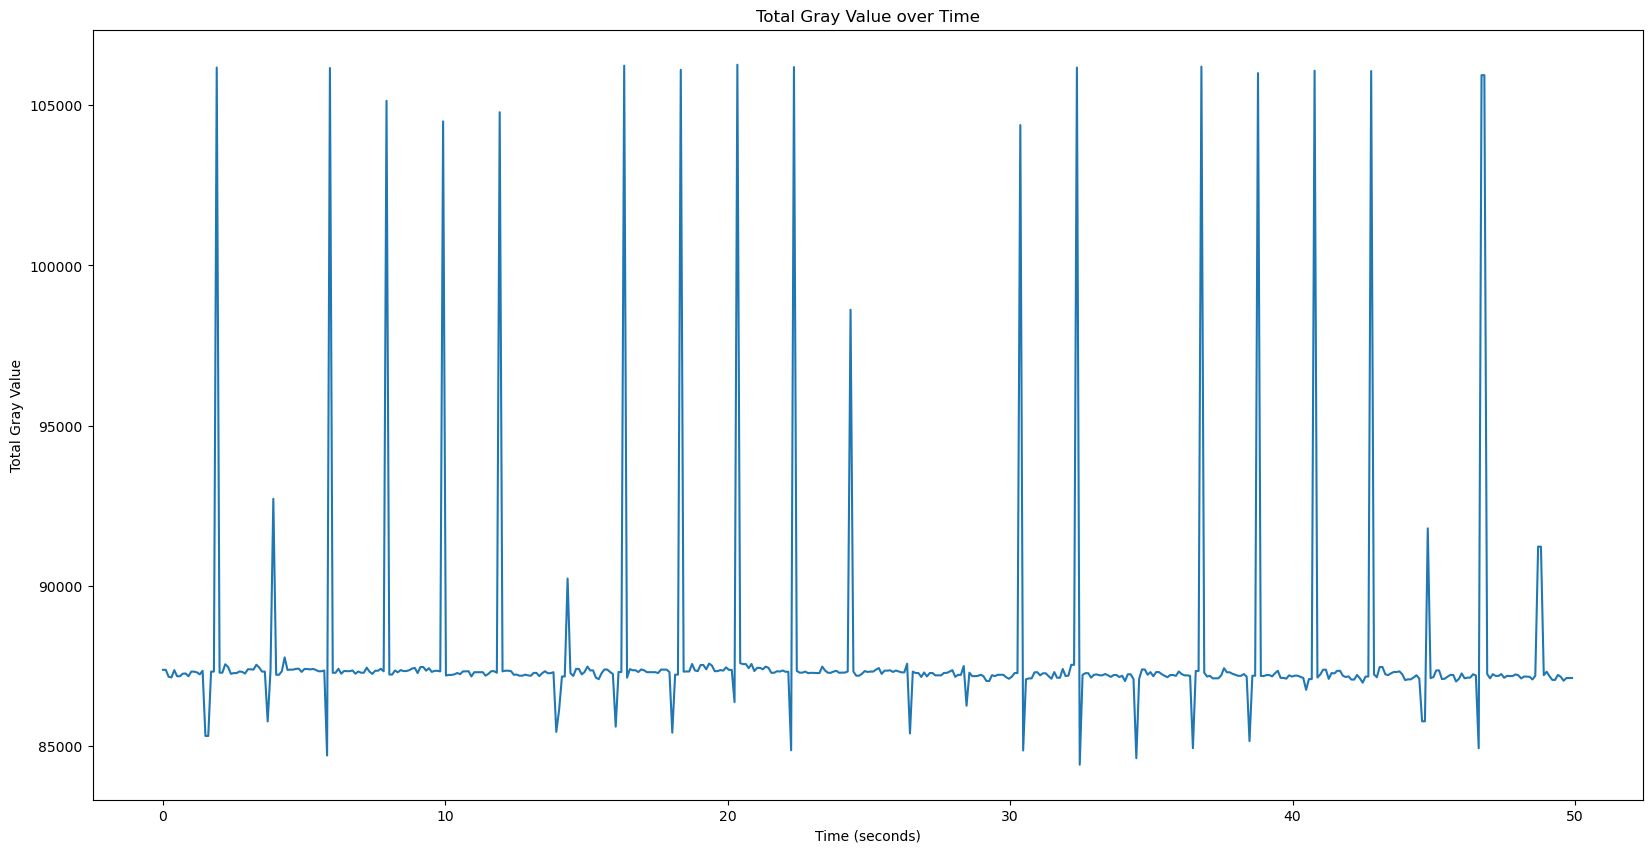

## Limit time interval, normalize, invert values and transform:

Enter desired x-axis limits (start,end) or press Enter to finish: 0,48


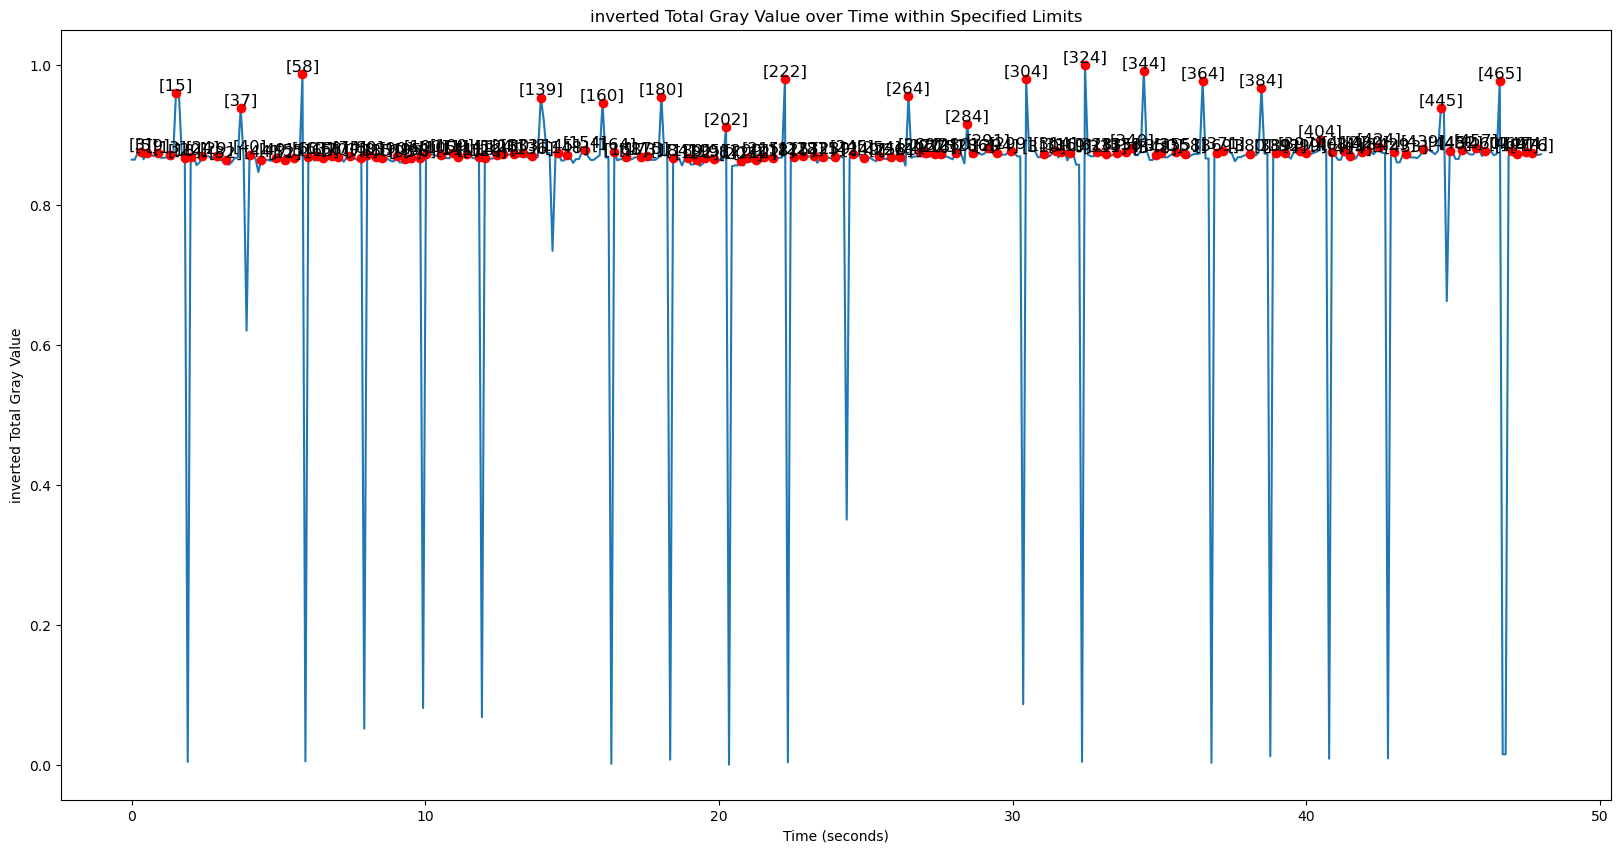

Enter desired x-axis limits (start,end) or press Enter to finish: 0,47


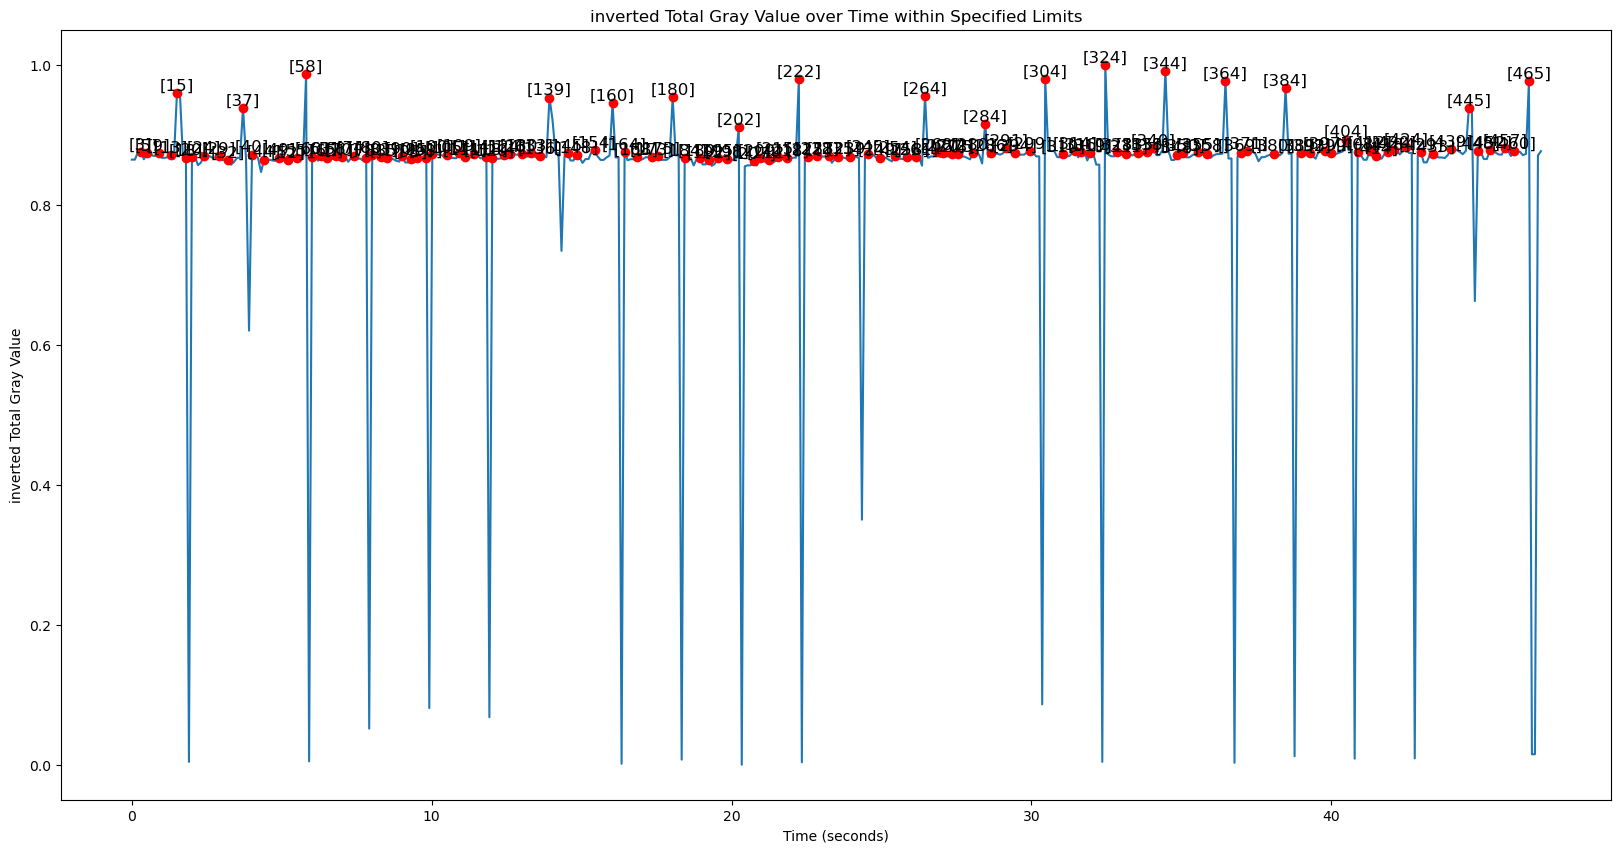

Enter desired x-axis limits (start,end) or press Enter to finish: 


In [61]:
%matplotlib inline
save=False

#========================================
# Functions to get directory to study
#========================================
def list_directories(path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d)) and d != '.ipynb_checkpoints']

def choose_directory(path):
    print("Directories in", path)
    directories = list_directories(path)
    for i, directory in enumerate(directories):
        print(f"{i+1}. {directory}")
    while True:
        choice = input("Choose a directory (1 - {}): ".format(len(directories)))
        if choice.isdigit() and 1 <= int(choice) <= len(directories):
            return directories[int(choice) - 1]
        
def select_roi(event, x, y, flags, param):
    global roi_selected, roi_start, roi_end, frame_copy

    if event == cv2.EVENT_LBUTTONDOWN:
        roi_start = (x, y)
        roi_selected = False
    elif event == cv2.EVENT_LBUTTONUP:
        roi_end = (x, y)
        roi_selected = True

    if roi_selected:
        frame_copy = frame.copy()
        cv2.rectangle(frame_copy, roi_start, roi_end, (0, 255, 0), 2)
        cv2.imshow("Select ROI", frame_copy)

#========================================
    
base_path = os.getcwd()
chosen_dir = choose_directory(base_path)
sub_path = os.path.join(base_path, chosen_dir)
chosen_subdir = choose_directory(sub_path)
video_path = os.path.join(sub_path, chosen_subdir, chosen_subdir + '.avi')
print("Video path:", video_path)


#========================================
# Open the video file
#========================================
cap = cv2.VideoCapture(video_path)

# Check if the video file is opened successfully
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

# Get the frame rate of the video
frame_rate = cap.get(cv2.CAP_PROP_FPS)
print("Frame rate:", frame_rate," fps")

#============================================
#ROI selection
#========================================
# Read the first frame
ret, frame = cap.read()
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Check if the frame is read correctly
if not ret:
    print("Error: Couldn't read frame.")
    read_correct=False
    cap.release()
    exit()
read_correct=True

# Initialize variables for ROI selection
roi_selected = False
roi_start = (0, 0)
roi_end = (0, 0)

# Create a window and set mouse callback to select ROI
cv2.namedWindow("Select ROI")
cv2.setMouseCallback("Select ROI", select_roi)

# Display the first frame
cv2.imshow("Select ROI", gray_frame)

# Wait for ROI selection
while not roi_selected:
    cv2.waitKey(1)

# Close the window
cv2.destroyWindow("Select ROI")

# Extract coordinates of ROI
x1, y1 = roi_start
x2, y2 = roi_end
#============================================

# Initialize a list to store total gray values for each frame
total_gray_values = []
total_frames=0
count_bad_frames=0

# Loop through all frames in the video
while True:
    if read_correct:
        # Process the frame, using the selected ROI (x1, y1, x2, y2)
        roi = gray_frame[y1:y2, x1:x2]
        # Calculate the total gray value of the frame
        total_gray_value = roi.sum()
        total_gray_values.append(total_gray_value)

        # Display the selected ROI on the frame
        gray_frame_copy = gray_frame.copy()
        cv2.rectangle(gray_frame_copy, roi_start, roi_end, (0, 255, 0), 2)
        cv2.imshow("Processed Frame", gray_frame_copy)
        total_frames+=1
    
    
    # Wait for key press
    key = cv2.waitKey(30)
    if key == 27:  # Press ESC to exit
        break

    # Read the next frame
    ret, frame = cap.read()
    if not ret:
        read_correct=False
        count_bad_frames+=1
        break
    read_correct=True  
    #========================================
    # Process frame
    # Here we can do modifications to each frame
    # right now we are just converting the frame to 
    # gray values since we are just interested in intensity
    # rather than color of the pixels
    #========================================
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #========================================

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()
#========================================

#========================================
# Plot total gray values for each frame
#========================================
display(Markdown('## Total gray values for each frame'))
# Plot the total gray values with specified figure size
plt.figure(figsize=(20, 10))
plt.plot(total_gray_values)
plt.xlabel('Frame Index')
plt.ylabel('Total Gray Value')
plt.title('Total Gray Value for Each Frame')
plt.show()

#========================================
# Plot total gray values vs elapsed time
#========================================
# Calculate time for each frame
time_per_frame = round(1 / frame_rate,1)

#times = np.arange(0, len(total_gray_values) * time_per_frame, time_per_frame)
times = np.linspace(0, len(total_gray_values) * time_per_frame, len(total_gray_values)) #Com np.linspace, especificas o número de pontos que queres, o que garante que o último valor seja exatamente o que esperas.

display(Markdown('# Converting frame index to time using the frame rate'))
# Plot the total gray values with time on the x-axis
plt.figure(figsize=(20, 10))
plt.plot(times, total_gray_values)
plt.xlabel('Time (seconds)')
plt.ylabel('Total Gray Value')
plt.title('Total Gray Value over Time')
if save:
    plt.savefig(os.path.join(sub_path, chosen_subdir,'Total_gray_value_vs_Time'))
plt.show()

display(Markdown('## Limit time interval, normalize, invert values and transform:'))
# Continuous prompt for x-axis limits
while True:
    # Prompt user for x-axis limits
    x_lim_input = input("Enter desired x-axis limits (start,end) or press Enter to finish: ")
    
    # If user presses Enter without entering any value, break the loop
    if x_lim_input == "":
        break
    
    # Parse user input for x-axis limits
    try:
        start, end = map(float, x_lim_input.split(","))
    except ValueError:
        print("Invalid input. Please enter two comma-separated numbers.")
        continue
    
    # Create a new list with total gray values within the specified limits
    total_gray_values_within_limits = []
    times_within_limits = []
    frames_idx_within_limits = []
    for i, time in enumerate(times):
        if start <= time <= end:
            total_gray_values_within_limits.append(total_gray_values[i])
            times_within_limits.append(time)
            frames_idx_within_limits.append(i)
    
    # Normalize the total gray values within the limits
    normalized_values = (total_gray_values_within_limits - np.min(total_gray_values_within_limits)) / (np.max(total_gray_values_within_limits) - np.min(total_gray_values_within_limits))

    #Invert values
    inverted_values = (normalized_values*-1)+1 
    
    # Find peaks in the normalized signal
    peaks, _ = find_peaks(inverted_values, height=0.5)

    # Calculate frequencies of peaks
    if len(peaks) >= 2:
        peak_times = np.array(times_within_limits)[peaks]
        peak_frames = np.array(times_within_limits)[peaks]
        peak_values = inverted_values[peaks]
    else:
        print("No peaks found.")

    #Get indexes of peaks within specified limit
    
    # List to store indices for each value
    peak_idxs = [[] for _ in range(len(peak_times))]

    # Iterate over the original list
    for i, value in enumerate(times):
        if value in peak_times:
            peak_idxs[np.where(peak_times == value)[0][0]].append(i)        
        
        
    # Plot the inverted total gray values within the limits
    plt.figure(figsize=(20, 10))
    plt.plot(times_within_limits, inverted_values)
    plt.plot(peak_times, peak_values, 'ro')
    
    # Add text with peak indices near each peak
    for peak_time, peak_value, peak_index in zip(peak_times, peak_values, peak_idxs):
        plt.text(peak_time, peak_value, str(peak_index), fontsize=12, color='black', ha='center', va='bottom')
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('inverted Total Gray Value')
    plt.title('inverted Total Gray Value over Time within Specified Limits')
    plt.show()
    

<h2><a id='filter_values'>
2. Filter valleys that would correspond to higher gray values
</a>
</h2>

In [62]:
# remove unwanted values
threshold=0.8
filtered_inverted_values = [v for v in inverted_values if v >= threshold]
filtered_times_within_limits = [t for v, t in zip(inverted_values, times_within_limits) if v >= threshold]
filtered_total_gray_values_within_limits = [item for v, item in zip(inverted_values, total_gray_values_within_limits) if v >= threshold]
filtered_frames_idx_within_limits = [t for v, t in zip(inverted_values, frames_idx_within_limits) if v >= threshold]

<h2><a id='peak_selection'>
3. Moving average for the filtered window and peak selection at a threshold above the moving average
</a>
</h2>

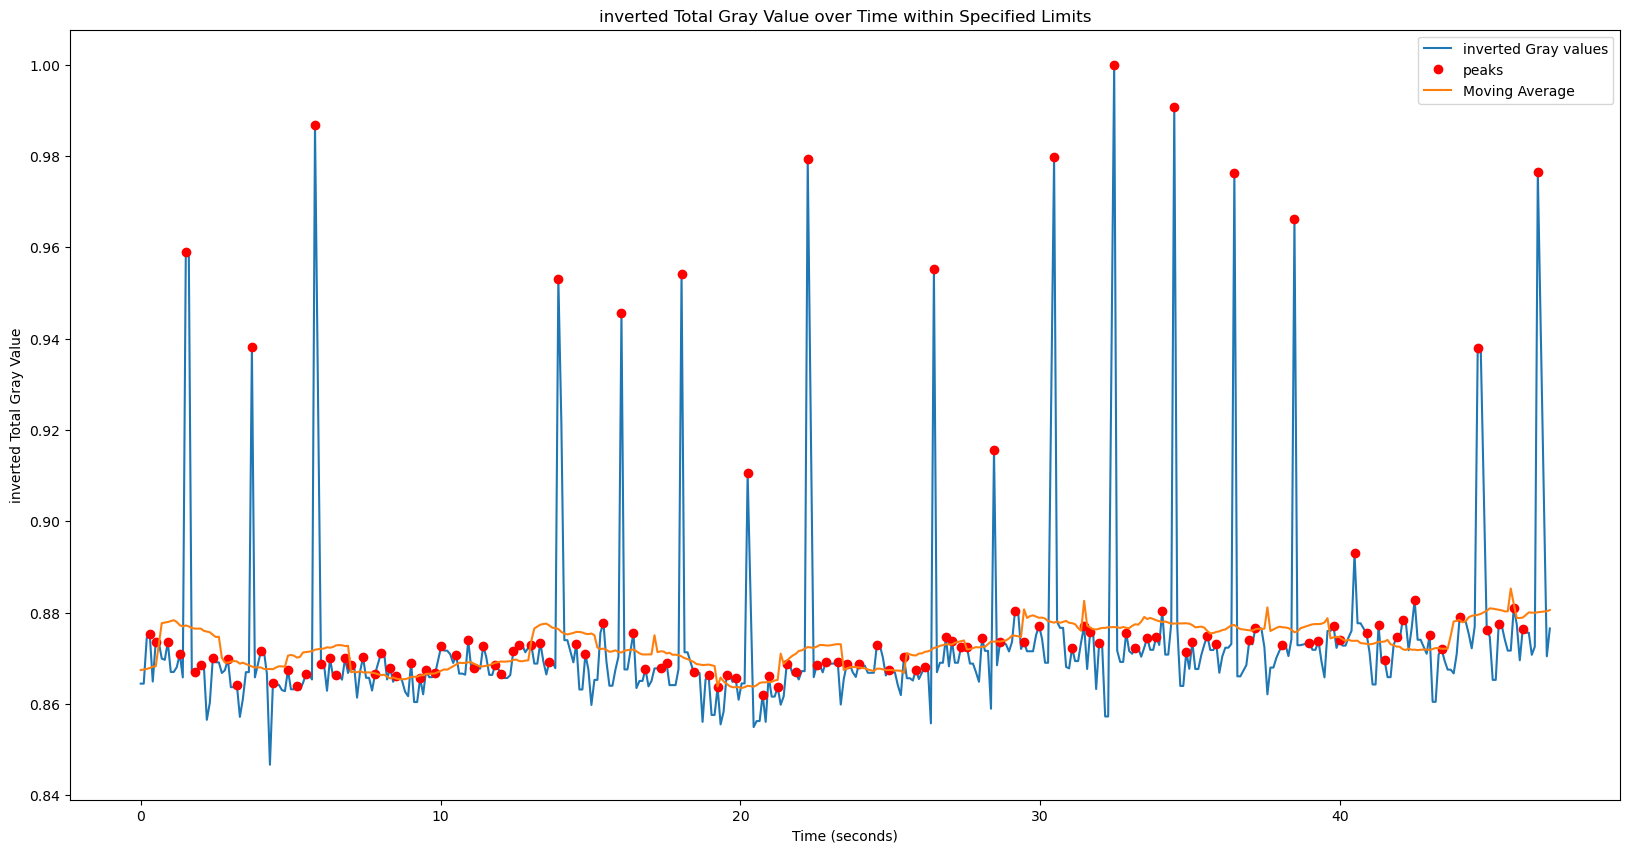

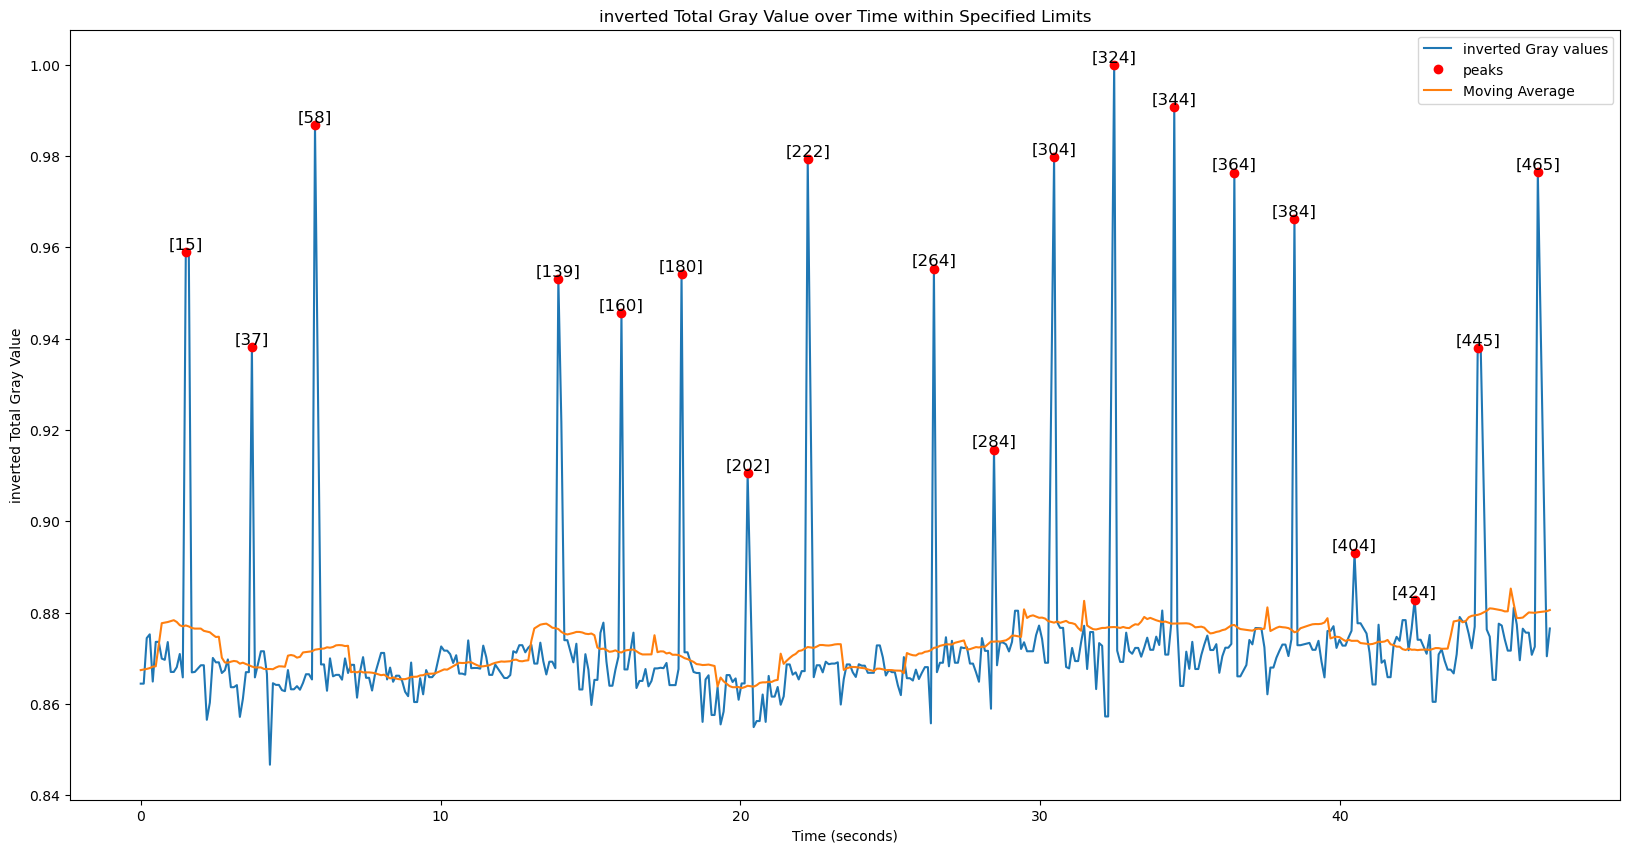

In [63]:
    
#-----------------------------------------------------------------------------------------------    
def moving_average(values, mv_average_window):
    """
    Compute the moving average of a list of values.

    Parameters:
        values (array-like): Input list of values.
        window_size (int): Size of the moving window.

    Returns:
        array-like: Moving average of the input values.
    """
    
    # Pad the signal to handle edge cases
    padded_signal = np.pad(values, (mv_average_window//2, mv_average_window//2), mode='edge')

    # Compute the moving average using a convolution
    weights = np.ones(mv_average_window) / mv_average_window
    moving_avg = np.convolve(padded_signal, weights, mode='valid')
    return moving_avg


mv_average_window=20    
mv_average=moving_average(filtered_inverted_values,mv_average_window)
# Plot the inverted total gray values within the limits
plt.figure(figsize=(20, 10))
plt.plot(filtered_times_within_limits, filtered_inverted_values,label='inverted Gray values')
plt.plot(peak_times, peak_values, 'ro',label='peaks')
#plt.plot(filtered_times_within_limits[mv_average_window - 1:], mv_average, label='Moving Average')
plt.plot(filtered_times_within_limits, mv_average[:-1], label='Moving Average')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('inverted Total Gray Value')
plt.title('inverted Total Gray Value over Time within Specified Limits')
plt.show()
    
offset_moving_average=0.01

# Find peaks in the normalized signal
peaks, _ = find_peaks(filtered_inverted_values, height=mv_average[:-1]+offset_moving_average)

# Calculate frequencies of peaks
if len(peaks) >= 2:
    peak_times = np.array(filtered_times_within_limits)[peaks]
    peak_frames = np.array(filtered_times_within_limits)[peaks]
    peak_values = np.array(filtered_inverted_values)[peaks]
else:
    print("No peaks found.")

#Get indexes of peaks within specified limit

# List to store indices for each value
peak_idxs = [[] for _ in range(len(peak_times))]

# Iterate over the original list
for i, value in enumerate(times):
    if value in peak_times:
        peak_idxs[np.where(peak_times == value)[0][0]].append(i)        

#valid for 4th in 26/2/24
#peak_times = peak_times[2:]
#peak_frames = peak_frames[2:]
#peak_values = peak_values[2:]
#peak_idxs = peak_idxs[2:]
        
# Plot the inverted total gray values within the limits
plt.figure(figsize=(20, 10))
plt.plot(filtered_times_within_limits, filtered_inverted_values,label='inverted Gray values')
plt.plot(peak_times, peak_values, 'ro',label='peaks')
plt.plot(filtered_times_within_limits, mv_average[:-1], label='Moving Average')

# Add text with peak indices near each peak
for peak_time, peak_value, peak_index in zip(peak_times, peak_values, peak_idxs):
    plt.text(peak_time, peak_value, str(peak_index), fontsize=12, color='black', ha='center', va='bottom')

plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('inverted Total Gray Value')
plt.title('inverted Total Gray Value over Time within Specified Limits')
if save:
    plt.savefig(os.path.join(sub_path, chosen_subdir,'Peak_selection_low_gray_values'))
plt.show()

#-----------------------------------------------------------------------------------------------

<h2><a id='ROI'>
4. Show selected ROI
</a>
</h2>

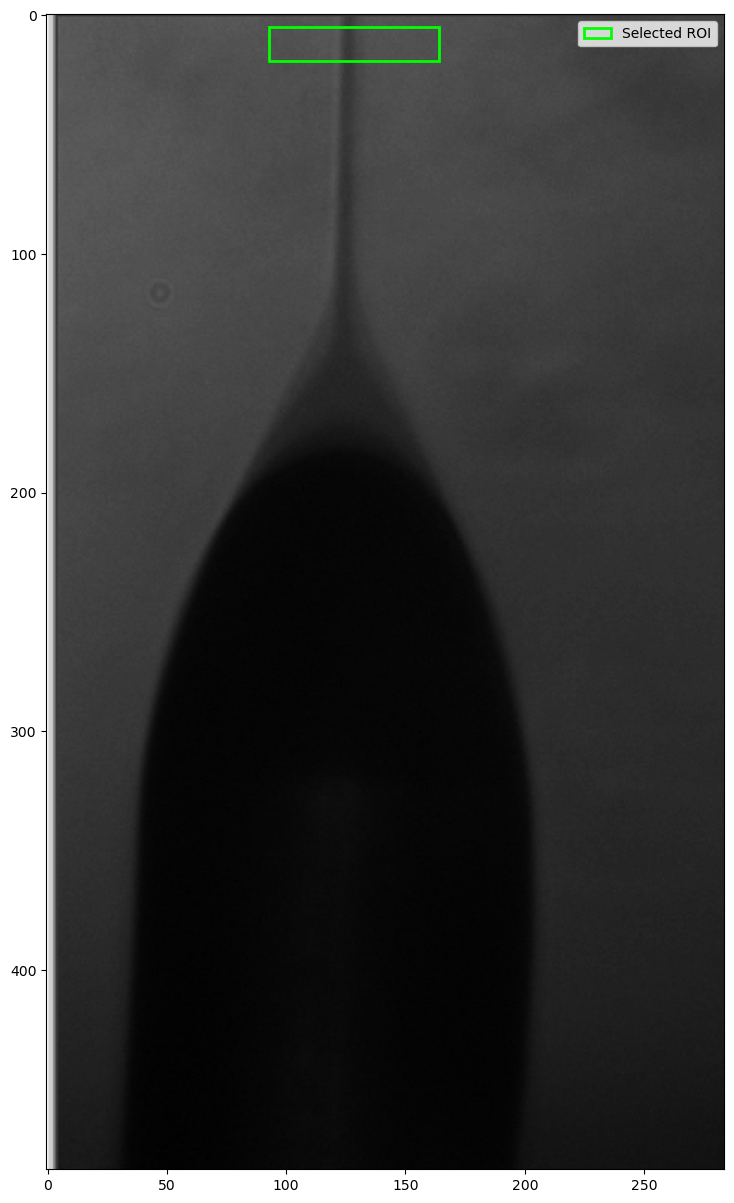

In [64]:
def show_ROI(cap,frame_index):
    # Set the frame position to the specified index
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # Read the frame
    ret, frame = cap.read()
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Check if the frame is read correctly
    if not ret:
        print("Error: Unable to read frame.")
        exit()

    # Create the plot<
    fig, ax = plt.subplots(figsize=(15, 15))
    im = ax.imshow(gray_frame,cmap='gray')
    
    # Extract coordinates of ROI
    x1, y1 = roi_start
    x2, y2 = roi_end
    
    # Calculate width and height
    width = x2 - x1
    height = y2 - y1

    # Create Rectangle patch
    rect = Rectangle((x1, y1), width, height, linewidth=2, edgecolor=(0, 1, 0), facecolor='none')
    # Add rectangle to the plot
    ax.add_patch(rect)
    legend_label = 'Selected ROI'
    ax.legend([rect], [legend_label], loc='upper right')
    if save:
        plt.savefig(os.path.join(sub_path, chosen_subdir,'Selected_ROI'))
    plt.show()


cap = cv2.VideoCapture(video_path)
show_ROI(cap,peak_idxs[0][0])
# Release the video capture object and close all windows
cap.release()

<h2><a id='peak_frames'>
5. Display the frame corresponding to each of the selected peaks
</a>
</h2>

## Frames corresponding to peak values:

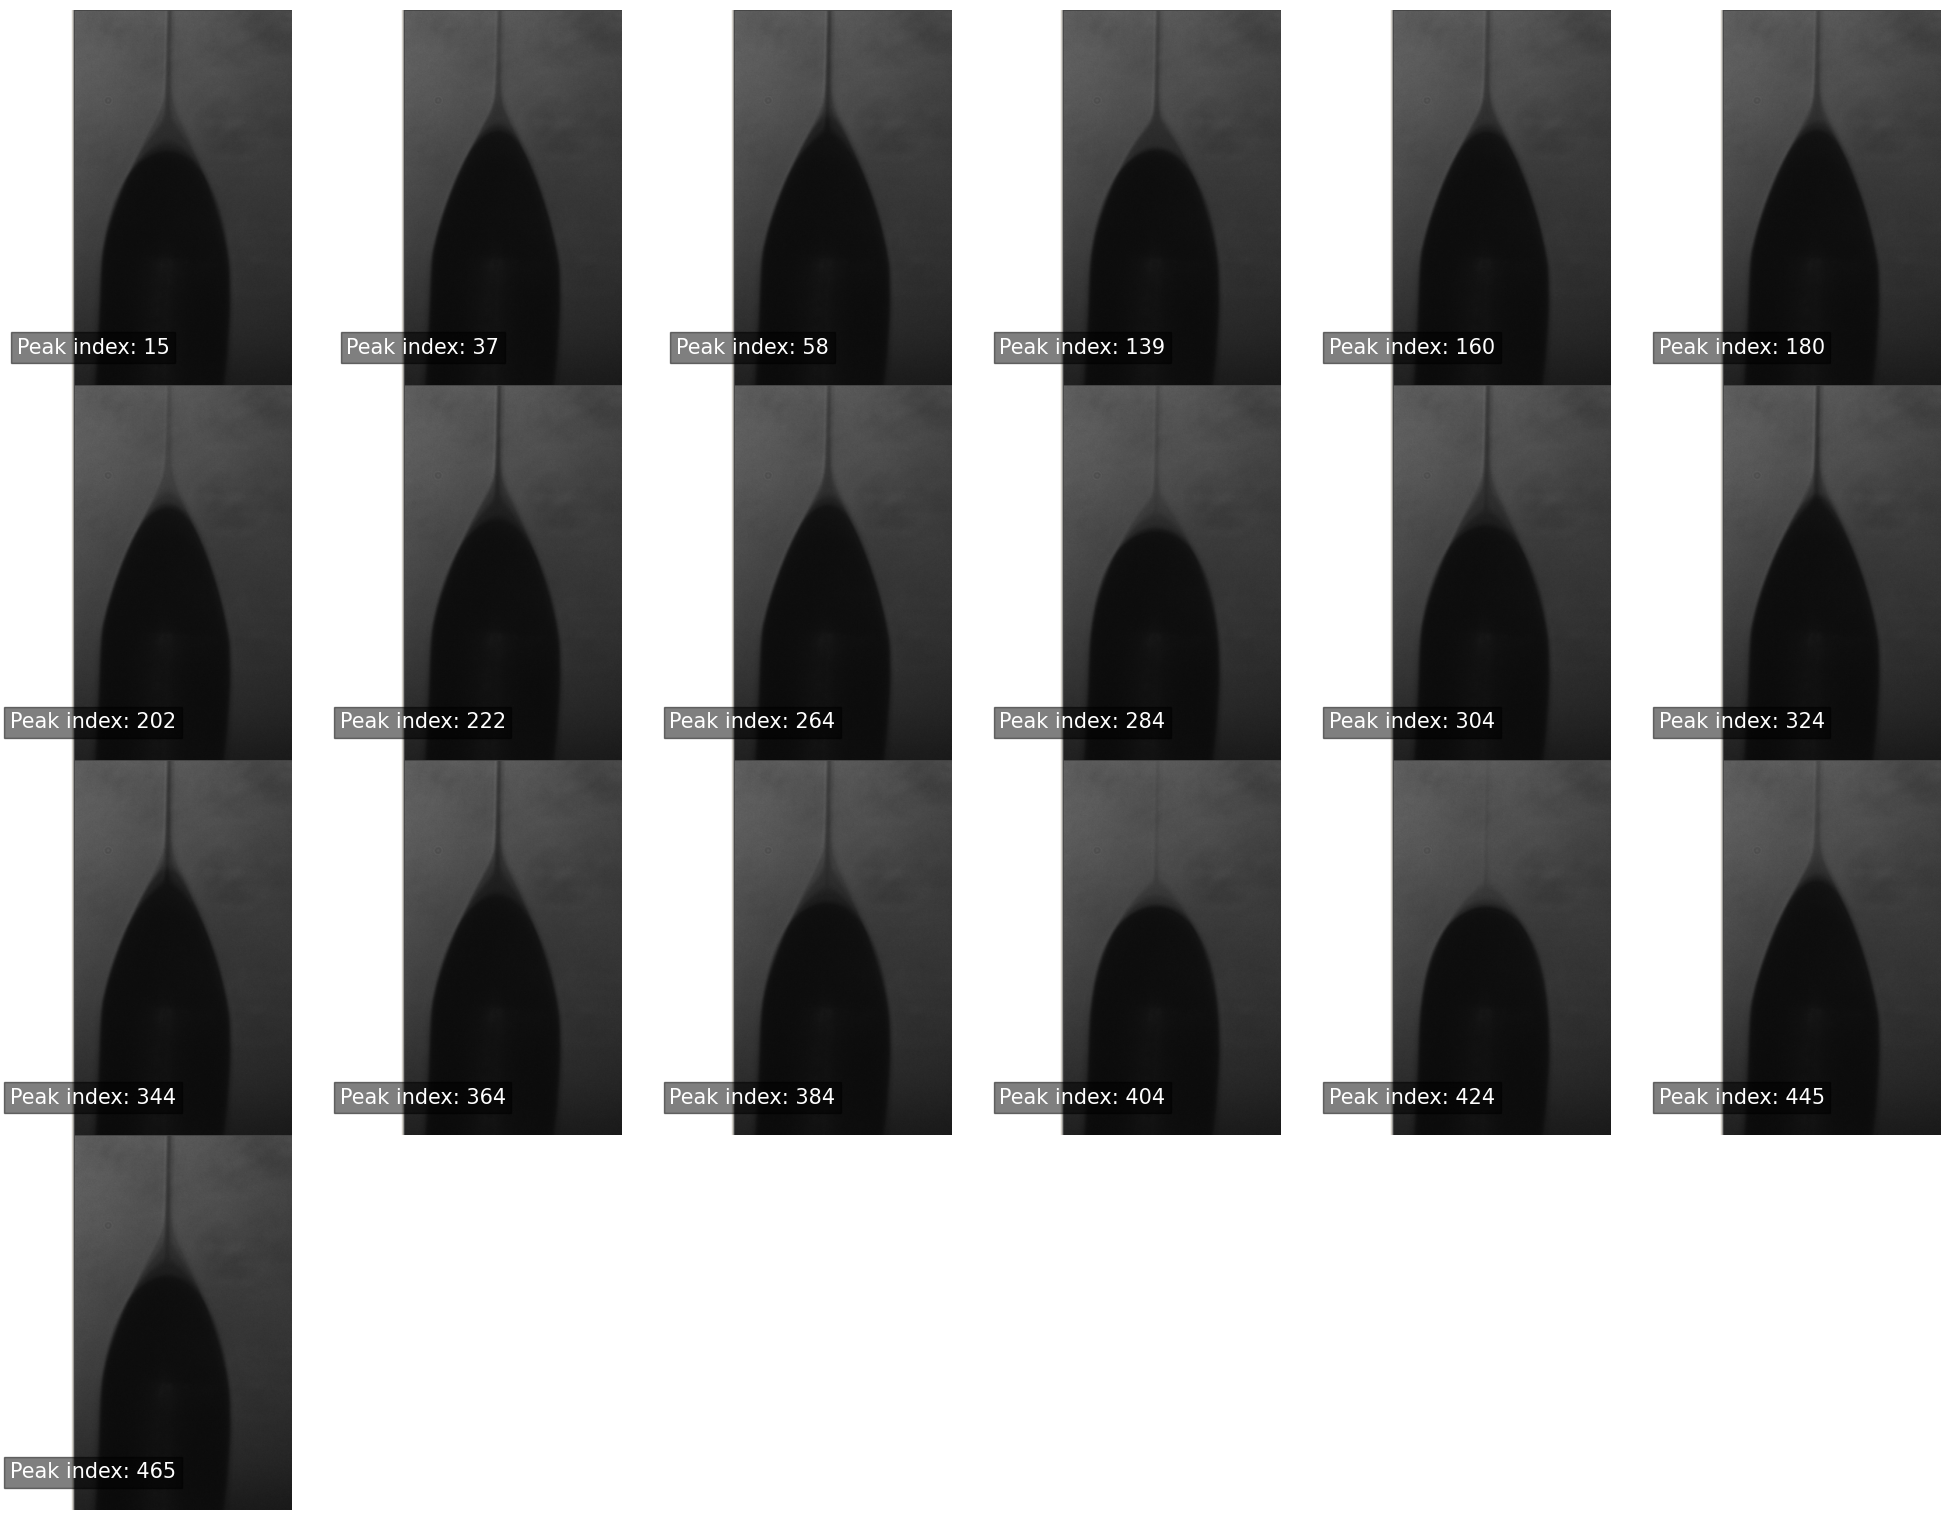

In [65]:
display(Markdown('## Frames corresponding to peak values:'))
#Print Frame of each peak
cap = cv2.VideoCapture(video_path)

# Check if the video file is opened successfully
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

# Create a subplot grid
num_cols = 6
num_rows = (len(peak_idxs) + num_cols - 1) // num_cols
plt.figure(figsize=(20, 15))
plt.subplots_adjust(wspace=0, hspace=0)  # Adjust spacing between subplots

for i, peak_idx in enumerate(peak_idxs):
    # Specify the frame index you want to open
    frame_index = peak_idx[0]  # Change this to the desired frame index

    # Set the frame position to the specified index
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # Read the frame
    ret, frame = cap.read()

    # Check if the frame is read correctly
    if not ret:
        print("Error: Unable to read frame.")
        exit()

    # Plot the frame in the subplot
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Add text with peak index to the plot
    plt.text(0.1, 0.1, f'Peak index: {frame_index}', fontsize=15, color='white',
             transform=ax.transAxes, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5))

# Release the video capture object and close all windows
cap.release()
plt.tight_layout(pad=0)  # Remove padding between subplots
if save:
    plt.savefig(os.path.join(sub_path, chosen_subdir,'Peak_frames'))
plt.show()

<h2><a id='statistics'>
6. Peak timing statistics
</a>
</h2>

## Histogram of time diference between plots and statistics:

Mean time difference between peaks: 2.5050200803212856 seconds
Standard deviation of time differences between peaks: 1.4493561181954244 seconds
Mean ejection frequency: 0.3991983967935871 Hz


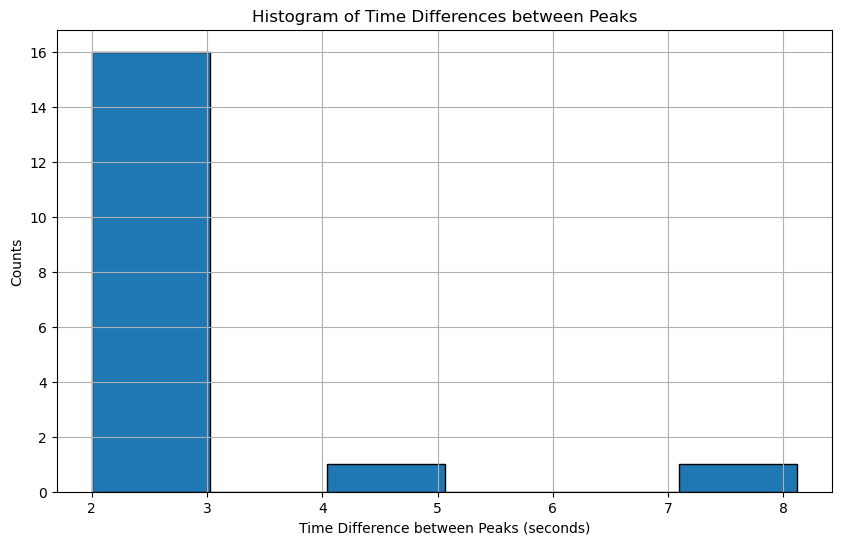

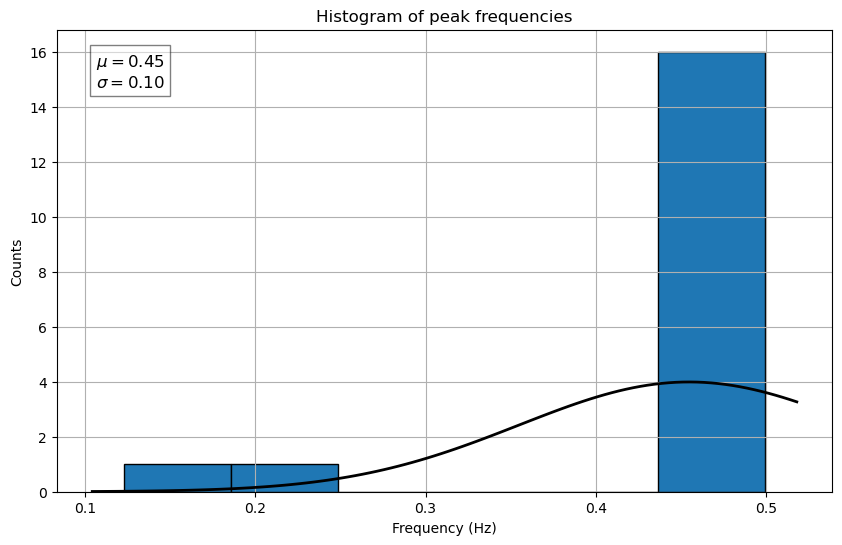

In [66]:
#STATISTICS 
display(Markdown('## Histogram of time diference between plots and statistics:'))    
# Calculate time differences between peaks
time_diffs = np.diff(peak_times)

# Compute statistics
mean_time_diff = np.mean(time_diffs)
std_time_diff = np.std(time_diffs)

print("Mean time difference between peaks:", mean_time_diff, "seconds")
print("Standard deviation of time differences between peaks:", std_time_diff, "seconds")
print("Mean ejection frequency:", 1/mean_time_diff, "Hz")

#num_bins = int(np.sqrt(len(time_diffs)))
num_bins = int(np.ceil(1 + np.log2(len(time_diffs))))

# Plot histogram of time differences
plt.figure(figsize=(10, 6))
plt.hist(time_diffs, bins=num_bins, edgecolor='black')
plt.xlabel('Time Difference between Peaks (seconds)')
plt.ylabel('Counts')
plt.title('Histogram of Time Differences between Peaks')
plt.grid(True)
plt.show()


# Plot histogram of frequency distribution
plt.figure(figsize=(10, 6))
plt.hist(1/time_diffs, bins=num_bins, edgecolor='black')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Counts')
plt.title('Histogram of peak frequencies')
plt.grid(True)

mu, std = norm.fit(1/time_diffs)  # Fit a normal distribution to the data
xmin, xmax = plt.xlim()  # Get limits of x-axis
x = np.linspace(xmin, xmax, 100)  # Create an array of x values
p = norm.pdf(x, mu, std)  # Calculate corresponding probabilities
plt.plot(x, p, 'k', linewidth=2)  # Plot normal distribution curve

# Add text annotation for mean and standard deviation inside the plot
plt.text(0.05, 0.95, f'$\mu={mu:.2f}$\n$\sigma={std:.2f}$', fontsize=12, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

if save:
    plt.savefig(os.path.join(sub_path, chosen_subdir,'Statistics'))
plt.show()

# display(Markdown('## FFT transform:')) 
# # Perform FFT on the normalized signal
# fft_values = fft(filtered_inverted_values)
# freq = np.fft.fftfreq(len(fft_values), d=time_per_frame)

# # Plot the FFT of the normalized signal
# plt.figure(figsize=(10, 6))
# plt.plot(freq[:len(freq)//2], np.abs(fft_values)[:len(freq)//2])
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.title('FFT of Normalized Signal')
# plt.show()

## Add results to csv

In [57]:
# with open("results.csv", 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Firing Frequency (Hz)', 'Backpressure (mm)', 'Pulse Mode', 'Peak Voltage (kV)', 'Nozzle to Substrate Distance (mm)','Mean time difference between peaks (s)','Standard deviation of time differences between peaks (s)','Mean ejection frequency (Hz)'])



In [67]:
pattern = r'(\d+)Hz_\+_(-?\d+\.\d+)mm_(\w+)_(-?\d+\.\d+)kV_(-?\d+\.\d+)mm\s*(?:\(\d+\))?'
match = re.match(pattern, chosen_subdir)
print(chosen_subdir)
if match:
    firing_frequency = match.group(1)
    backpressure = match.group(2)
    pulse_mode = match.group(3)
    peak_voltage = match.group(4)
    nozzle_distance = match.group(5)
    print(firing_frequency, backpressure, pulse_mode, peak_voltage, nozzle_distance)
    # Sample row data
    row = [firing_frequency, backpressure, pulse_mode, peak_voltage, nozzle_distance,mean_time_diff,std_time_diff,1/mean_time_diff]

    # Open or create the CSV file in write mode
    with open('results.csv', 'a', newline='') as csvfile:
        # Create a CSV writer object
        csvwriter = csv.writer(csvfile)

        # Write the row to the CSV file
        csvwriter.writerow(row)
else:
    print("No pattern")
   

50Hz_+_25.0mm_DC_1.49kV_1.3mm
50 25.0 DC 1.49 1.3


<h1><a id='tests'>
Tests
</a>
</h1>

In [48]:
#video_path='50Hz_cut.avi'
cap = cv2.VideoCapture(video_path)

for i in range(290,32):
    #print(i)
    show_frame_idx(cap,i)

# Release the video capture object and close all windows
cap.release()

In [47]:
def show_frame_idx2(cap,frame_index):
    # Set the frame position to the specified index
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # Read the frame
    ret, frame = cap.read()
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate the total gray value of the frame
    total_gray_value = gray_frame.sum()
    print("Frame: ",frame_index," Total gray value: ",total_gray_value)

    # Check if the frame is read correctly
    if not ret:
        print("Error: Unable to read frame.")
        exit()
        
    plt.figure()
    plt.imshow(gray_frame)
    plt.show()
    
    #Linear regression

    # Define the region of interest (ROI) coordinates
    x1, y1 = 400, 0  # Top-left corner of ROI
    x2, y2 = 600, 150  # Bottom-right corner of ROI

    # Extract the ROI
    roi = gray_frame[y1:y2, x1:x2]

    # Flatten the ROI to use it for linear regression
    X = np.arange(len(roi.flatten())).reshape(-1, 1)
    y = roi.flatten().reshape(-1, 1)

    # Fit linear regression model
    model = LinearRegression().fit(X, y)

    # Get the coefficients of the linear regression line
    slope = model.coef_[0][0]
    intercept = model.intercept_[0]

    # Adjust all pixel values in the ROI using the linear regression line
    adjusted_roi = (slope * X + intercept).reshape(roi.shape)
    
    gray_frame2=gray_frame
    # Replace the ROI in the original image with the adjusted ROI
    gray_frame2[y1:y2, x1:x2] = adjusted_roi.astype(np.uint8)


    # Plot the result
    plt.figure()
    plt.imshow(gray_frame2)
    plt.show()
    
    # Create a mask of zeros with the same size as the image
    mask = np.zeros_like(gray_frame)

    # Define the coordinates of the rectangle (x, y, width, height)
    x, y, width, height = 180, 0, 200, 500

    # Draw the rectangle on the mask
    cv2.rectangle(mask, (x, y), (x + width, y + height), 255, thickness=cv2.FILLED)

    # Set pixels outside the rectangle to 255 in the original image
    gray_frame[mask == 0] = 255
    
    
    ################# Gaussian blur
    # Apply Gaussian blur to smooth the image (optional, helps with noise)
    blurred = cv2.GaussianBlur(gray_frame, (5, 5), 0)

    # Choose an appropriate threshold value
    _, thresholded = cv2.threshold(blurred, 25, 255, cv2.THRESH_BINARY)

    # Invert the thresholded image to have the background as white and object as black
    thresholded = cv2.bitwise_not(thresholded)

    # Perform morphological operations to further clean up the image (optional)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    thresholded = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel)
    thresholded = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)
    # Plot the result
    plt.figure()
    plt.imshow(thresholded)
    plt.show()
    

#video_path2='50Hz_cut2.avi'
cap = cv2.VideoCapture(video_path)

show_frame_idx(cap,486)

# Release the video capture object and close all windows
cap.release()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
# Load the grayscale image
image = cv2.imread('your_image.jpg', cv2.IMREAD_GRAYSCALE)

# Define the region of interest (ROI) coordinates
x1, y1 = 100, 100  # Top-left corner of ROI
x2, y2 = 200, 200  # Bottom-right corner of ROI

# Extract the ROI
roi = image[y1:y2, x1:x2]

# Flatten the ROI to use it for linear regression
X = np.arange(len(roi.flatten())).reshape(-1, 1)
y = roi.flatten().reshape(-1, 1)

# Fit linear regression model
model = LinearRegression().fit(X, y)

# Get the coefficients of the linear regression line
slope = model.coef_[0][0]
intercept = model.intercept_[0]

# Adjust all pixel values in the ROI using the linear regression line
adjusted_roi = (slope * X + intercept).reshape(roi.shape)

# Replace the ROI in the original image with the adjusted ROI
image[y1:y2, x1:x2] = adjusted_roi.astype(np.uint8)

# Plot the result
cv2.imshow('Adjusted Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Frame:  319  Total gray value:  11072684


<IPython.core.display.Javascript object>


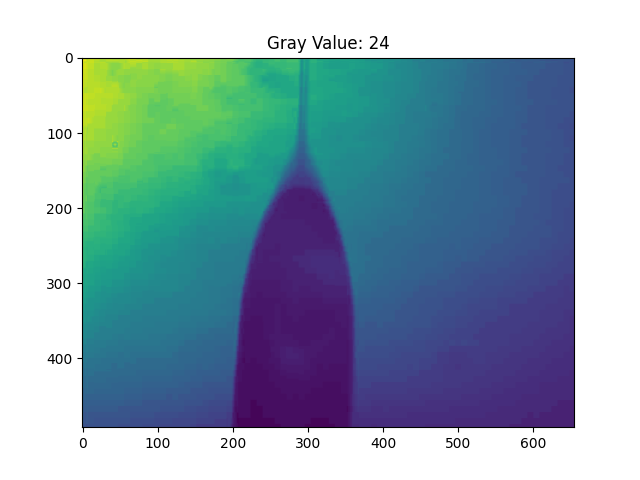

In [49]:
def show_frame_idx(cap,frame_index):
    # Set the frame position to the specified index
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # Read the frame
    ret, frame = cap.read()
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate the total gray value of the frame
    total_gray_value = gray_frame.sum()
    print("Frame: ",frame_index," Total gray value: ",total_gray_value)

    # Check if the frame is read correctly
    if not ret:
        print("Error: Unable to read frame.")
        exit()

    # Create the plot
    fig, ax = plt.subplots()
    im = ax.imshow(gray_frame)
    # Define the function to update the text when hovering over a pixel
    def hover(event):
        if event.inaxes == ax:
            x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)  # Round to nearest pixel
            if 0 <= x < gray_frame.shape[1] and 0 <= y < gray_frame.shape[0]:
                intensity = gray_frame[y, x]
                ax.set_title(f'Gray Value: {intensity}')
            else:
                ax.set_title('')
            fig.canvas.draw_idle()

    # Connect the event handler
    fig.canvas.mpl_connect('motion_notify_event', hover)
    plt.show()
        
    #plt.figure()
    #plt.imshow(gray_frame)
    #plt.show()

video_path='50Hz_cut2.avi'
cap = cv2.VideoCapture(video_path)

show_frame_idx(cap,319)

# Release the video capture object and close all windows
cap.release()

<IPython.core.display.Javascript object>


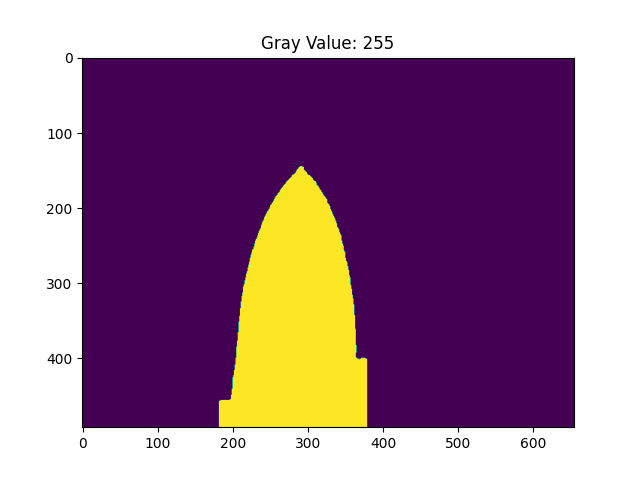

In [64]:
def show_frame_idx(cap,frame_index):
    # Set the frame position to the specified index
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # Read the frame
    ret, frame = cap.read()
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #---------------------------------------------------------------

    # Create a mask of zeros with the same size as the image
    mask = np.zeros_like(gray_frame)

    # Define the coordinates of the rectangle (x, y, width, height)
    x, y, width, height = 180, 0, 200, 500

    # Draw the rectangle on the mask
    cv2.rectangle(mask, (x, y), (x + width, y + height), 255, thickness=cv2.FILLED)

    # Set pixels outside the rectangle to 255 in the original image
    gray_frame[mask == 0] = 255
    
    
    ################# Gaussian blur
    # Apply Gaussian blur to smooth the image (optional, helps with noise)
    blurred = cv2.GaussianBlur(gray_frame, (5, 5), 0)

    # Choose an appropriate threshold value
    _, thresholded = cv2.threshold(blurred, 23, 255, cv2.THRESH_BINARY)

    # Invert the thresholded image to have the background as white and object as black
    thresholded = cv2.bitwise_not(thresholded)

    # Perform morphological operations to further clean up the image (optional)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    thresholded = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel)
    thresholded = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)

    #---------------------------------------------------------------

    # Check if the frame is read correctly
    if not ret:
        print("Error: Unable to read frame.")
        exit()

    # Create the plot
    fig, ax = plt.subplots()
    im = ax.imshow(thresholded)
    # Define the function to update the text when hovering over a pixel
    def hover(event):
        if event.inaxes == ax:
            x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)  # Round to nearest pixel
            if 0 <= x < thresholded.shape[1] and 0 <= y < thresholded.shape[0]:
                intensity = gray_frame[y, x]
                ax.set_title(f'Gray Value: {intensity}')
            else:
                ax.set_title('')
            fig.canvas.draw_idle()

    # Connect the event handler
    fig.canvas.mpl_connect('motion_notify_event', hover)
    plt.show()
        
    #plt.figure()
    #plt.imshow(gray_frame)
    #plt.show()

video_path='50Hz_cut2.avi'
cap = cv2.VideoCapture(video_path)

show_frame_idx(cap,319)

# Release the video capture object and close all windows
cap.release()